# 🌊 Detección de Remolinos con Métodos Físicos: CHE11, NEN10 y HAL13

03/02/2025

En este notebook se implementan **tres métodos físicos** para la detección de remolinos en datos satelitales:

1. **CHE11 (Chelton et al., 2011)** → Detección basada en contornos cerrados de **SLA**.
2. **NEN10 (Nencioli et al., 2010)** → Método basado en la geometría de velocidades.
3. **HAL13 (Halo et al., 2013)** → Combinación del parámetro **Okubo-Weiss** con contornos cerrados.

Los tres métodos se aplican a los datos del producto **NeurOST**, con resolución de **1 km** y frecuencia diaria.


## 📌 3️⃣ Método HAL13: Okubo-Weiss y Contornos Cerrados

El método **Halo et al. (2013)** combina:

- **El parámetro Okubo-Weiss (\( W \))** → Cuantifica la dominancia de la rotación frente a la deformación del flujo.
- **Contornos cerrados de SLA** → Para filtrar estructuras coherentes.

### 🔹 **Pasos del método:**
1. Calcular el parámetro **Okubo-Weiss (\( W \))**:

   \[
   W = S_n^2 + S_s^2 - \zeta^2
   \]

   donde:
   - \( S_n \), \( S_s \) son las deformaciones normal y de cizalla.
   - \( \zeta \) es la vorticidad relativa.

2. Aplicar un umbral a \( W \) para identificar regiones de remolinos.

3. Filtrar solo aquellas regiones con contornos cerrados de SLA.


In [32]:
from netCDF4 import Dataset

archivo = r"anomalia_SLA_GC_NeurOST.nc"
nc = Dataset(archivo, "r")
print(nc)
print("Variables disponibles:")
for var in nc.variables:
    print(var)
nc.close()


<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(896), lat(110), lon(100)
    variables(dimensions): float32 sla_anomaly(time, lat, lon), int64 time(time), float64 lat(lat), float64 lon(lon)
    groups: 
Variables disponibles:
sla_anomaly
time
lat
lon


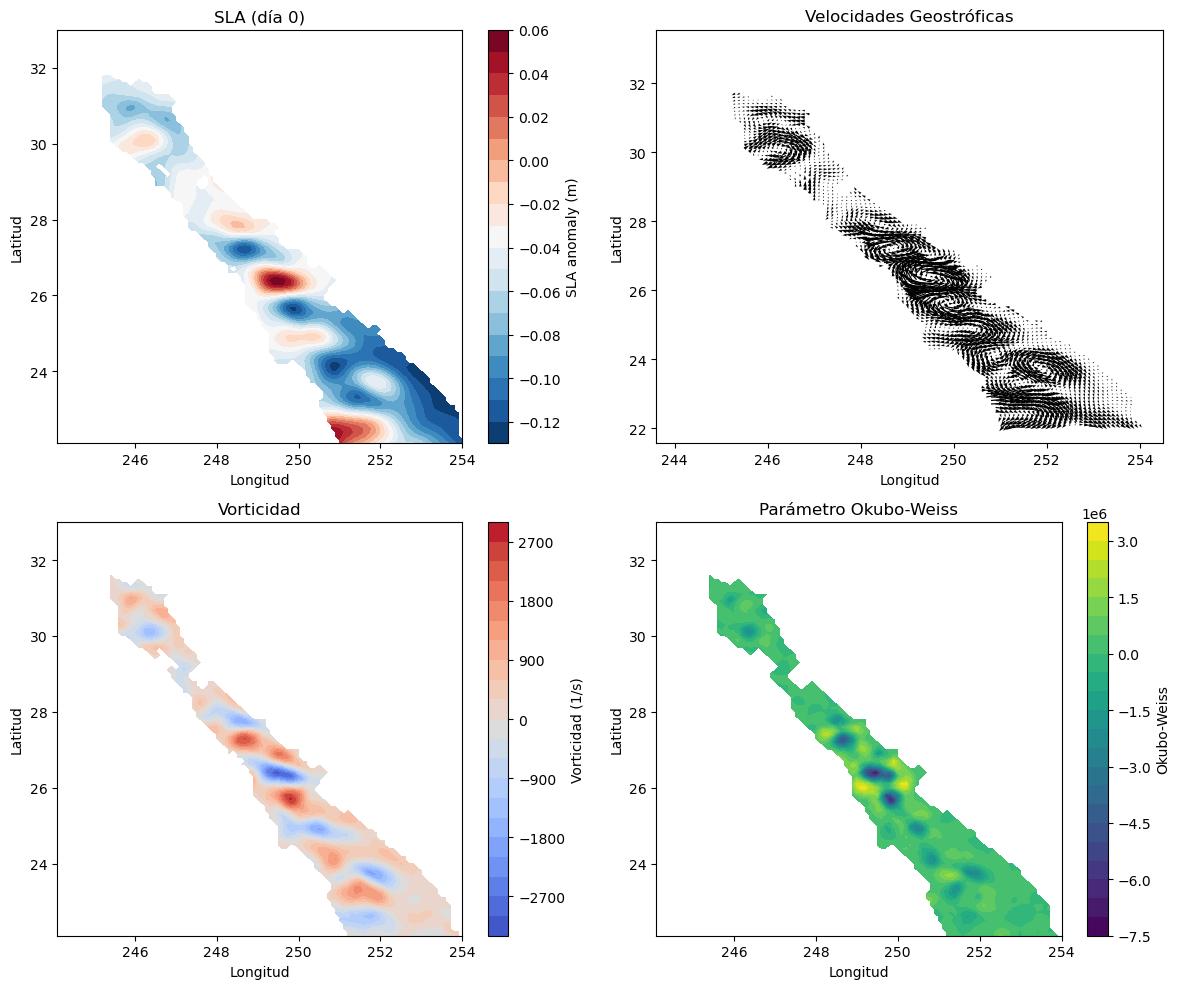

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Funciones para calcular velocidades geostróficas, vorticidad y Okubo-Weiss
# -------------------------------

def calcular_velocidades_geostroficas(sla, lat, lon, g=9.81):
    """
    Calcula las velocidades geostróficas u y v a partir del campo de SLA.
    
    u = - (g / f) * dη/dy  
    v =   (g / f) * dη/dx
    
    Se calcula f usando la latitud promedio de la región.
    
    Parámetros:
      - sla: array 2D de SLA (m) con forma (lat, lon).
      - lat: vector de latitudes (en grados).
      - lon: vector de longitudes (en grados).
      - g: aceleración de la gravedad (m/s²).
      
    Devuelve:
      - u, v: arrays 2D de velocidades geostróficas.
    """
    Omega = 7.2921e-5  # rotación de la Tierra en rad/s
    lat_mean = np.mean(lat)
    f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
    # Suponiendo que la malla es regular; aquí dx y dy se definen como 1 (puedes ajustar)
    dx = 1.0
    dy = 1.0
    # np.gradient devuelve primero la derivada respecto al eje 0 (latitud) y luego respecto al eje 1 (longitud)
    dSLA_dy, dSLA_dx = np.gradient(sla, dy, dx)
    u = - (g / f) * dSLA_dy
    v = (g / f) * dSLA_dx
    return u, v

def calcular_vorticidad(u, v, dx=1.0, dy=1.0):
    """
    Calcula la vorticidad zeta = dv/dx - du/dy.
    """
    du_dy, du_dx = np.gradient(u, dy, dx)
    dv_dy, dv_dx = np.gradient(v, dy, dx)
    zeta = dv_dx - du_dy
    return zeta

def calcular_okubo_weiss(u, v, dx, dy):
    """
    Calcula el parámetro de Okubo-Weiss (W) a partir de u y v.
    """
    du_dx = np.gradient(u, dx, axis=1)
    du_dy = np.gradient(u, dy, axis=0)
    dv_dx = np.gradient(v, dx, axis=1)
    dv_dy = np.gradient(v, dy, axis=0)
    Sn = du_dx - dv_dy
    Ss = du_dy + dv_dx
    zeta = dv_dx - du_dy
    W = Sn**2 + Ss**2 - zeta**2
    return W

# -------------------------------
# 1. Abrir el archivo y seleccionar el día 0
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
ds0 = ds.isel(time=0)  # Día 0

# Extraer el campo de SLA y las coordenadas
sla = ds0["sla_anomaly"].values  # forma (lat, lon)
lat_vec = ds0["lat"].values        # vector de latitudes (110 elementos)
lon_vec = ds0["lon"].values        # vector de longitudes (100 elementos)

# -------------------------------
# 2. Calcular velocidades, vorticidad y Okubo-Weiss
# -------------------------------
u, v = calcular_velocidades_geostroficas(sla, lat_vec, lon_vec)
zeta = calcular_vorticidad(u, v, dx=1.0, dy=1.0)
W = calcular_okubo_weiss(u, v, dx=1.0, dy=1.0)

# -------------------------------
# 3. Visualización de los campos
# -------------------------------
plt.figure(figsize=(12,10))

# SLA
plt.subplot(2,2,1)
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap='RdBu_r')
plt.colorbar(label="SLA anomaly (m)")
plt.title("SLA (día 0)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

# Velocidades Geostróficas (u, v)
plt.subplot(2,2,2)
plt.quiver(lon_vec, lat_vec, u, v, scale=100000)
plt.title("Velocidades Geostróficas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

# Vorticidad
plt.subplot(2,2,3)
plt.contourf(lon_vec, lat_vec, zeta, levels=20, cmap='coolwarm')
plt.colorbar(label="Vorticidad (1/s)")
plt.title("Vorticidad")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

# Okubo-Weiss
plt.subplot(2,2,4)
plt.contourf(lon_vec, lat_vec, W, levels=20, cmap='viridis')
plt.colorbar(label="Okubo-Weiss")
plt.title("Parámetro Okubo-Weiss")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

plt.tight_layout()
plt.show()

ds.close()


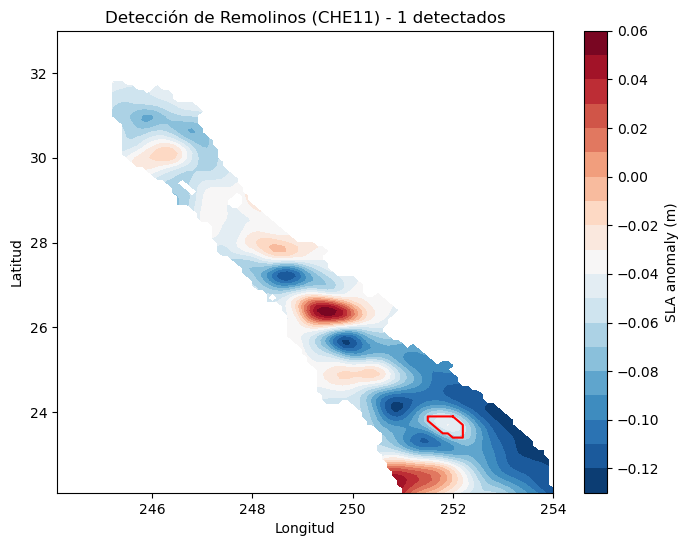

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# -------------------------------
# 1. Detectar contornos cerrados en SLA (CHE11)
# -------------------------------
niveles_sla = np.linspace(np.nanmin(sla), np.nanmax(sla), 10)  # Definir niveles de contorno
contornos = measure.find_contours(sla, level=np.nanmedian(sla))  # Buscar contornos cerrados en SLA

# -------------------------------
# 2. Filtrar contornos cerrados y calcular radios
# -------------------------------
remolinos = []
for contorno in contornos:
    x_cont, y_cont = contorno[:, 1], contorno[:, 0]  # Convertir índices a longitudes y latitudes
    
    # Verificar si el contorno es cerrado
    if np.allclose(contorno[0], contorno[-1], atol=1):  
        # Calcular radio medio del remolino
        centro_x, centro_y = np.mean(x_cont), np.mean(y_cont)
        distancias = np.sqrt((x_cont - centro_x)**2 + (y_cont - centro_y)**2)
        radio_medio = np.mean(distancias)
        
        # Guardar la información del remolino
        remolinos.append({"centro": (centro_x, centro_y), "radio": radio_medio, "contorno": contorno})

# -------------------------------
# 3. Visualización de remolinos detectados
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")  # SLA como fondo
plt.colorbar(label="SLA anomaly (m)")

# Dibujar los contornos detectados
for remolino in remolinos:
    plt.plot(lon_vec[remolino["contorno"][:, 1].astype(int)], 
             lat_vec[remolino["contorno"][:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (CHE11) - {len(remolinos)} detectados")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


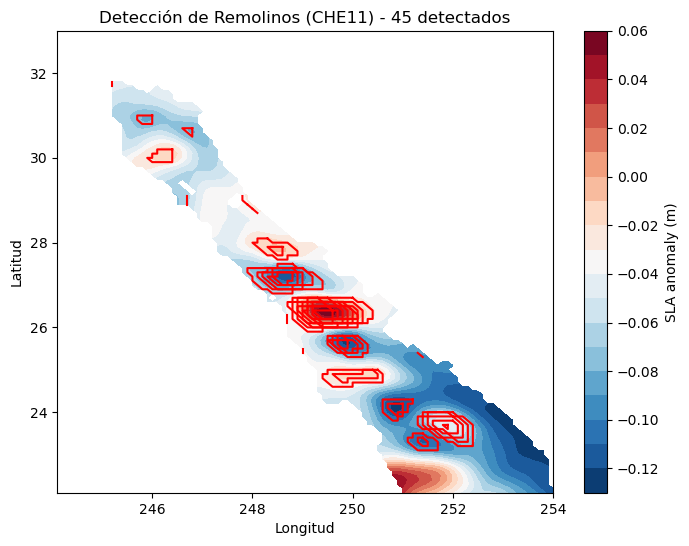

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# -------------------------------
# 1. Generar los niveles de contorno de SLA
# -------------------------------
plt.figure(figsize=(8, 6))
contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")  # Dibujar SLA con niveles reales
niveles_sla = contorno_figura.levels  # Extraer los niveles usados
plt.close()  # Cerrar la figura porque solo queremos los niveles

# -------------------------------
# 2. Detectar contornos en SLA usando los niveles extraídos
# -------------------------------
contornos_detectados = []
for nivel in niveles_sla:
    contornos = measure.find_contours(sla, level=nivel)  # Detectar contornos en cada nivel
    for contorno in contornos:
        x_cont, y_cont = contorno[:, 1], contorno[:, 0]  # Convertir índices a longitudes y latitudes
        
        # Verificar si el contorno está cerrado
        if np.allclose(contorno[0], contorno[-1], atol=2):
            contornos_detectados.append(contorno)

# -------------------------------
# 3. Visualización de remolinos detectados
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=niveles_sla, cmap="RdBu_r")  # SLA como fondo
plt.colorbar(label="SLA anomaly (m)")

# Dibujar los contornos detectados
for contorno in contornos_detectados:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], 
             lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (CHE11) - {len(contornos_detectados)} detectados")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


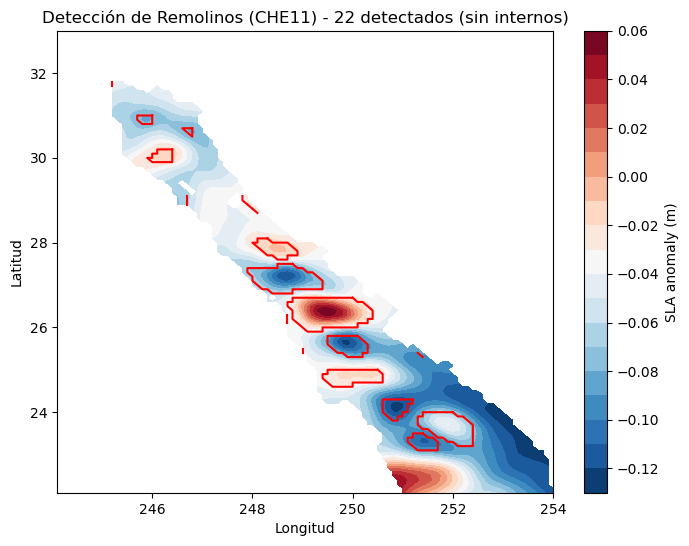

In [5]:
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# -------------------------------
# 1. Generar los niveles de contorno de SLA
# -------------------------------
plt.figure(figsize=(8, 6))
contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")  # Dibujar SLA con niveles reales
niveles_sla = contorno_figura.levels  # Extraer los niveles usados
plt.close()  # Cerrar la figura porque solo queremos los niveles

# -------------------------------
# 2. Detectar contornos en SLA usando los niveles extraídos
# -------------------------------
contornos_detectados = []
for nivel in niveles_sla:
    contornos = measure.find_contours(sla, level=nivel)  # Detectar contornos en cada nivel
    for contorno in contornos:
        x_cont, y_cont = contorno[:, 1], contorno[:, 0]  # Convertir índices a longitudes y latitudes
        
        # Verificar si el contorno está cerrado
        if np.allclose(contorno[0], contorno[-1], atol=2):
            contornos_detectados.append(contorno)

# -------------------------------
# 3. Filtrar contornos internos para evitar duplicados
# -------------------------------
contornos_filtrados = []
for i, contorno_externo in enumerate(contornos_detectados):
    path_externo = Path(contorno_externo)  # Convertir a un Path para ver si contiene otros
    
    # Comprobar si algún otro contorno más grande lo engloba
    es_interno = False
    for j, contorno_otro in enumerate(contornos_detectados):
        if i != j:  # No compararse consigo mismo
            path_otro = Path(contorno_otro)
            if path_otro.contains_path(path_externo):
                es_interno = True
                break  # Si ya está contenido, no hace falta seguir comprobando
    
    if not es_interno:
        contornos_filtrados.append(contorno_externo)

# -------------------------------
# 4. Visualización de remolinos detectados filtrando internos
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=niveles_sla, cmap="RdBu_r")  # SLA como fondo
plt.colorbar(label="SLA anomaly (m)")

# Dibujar los contornos detectados
for contorno in contornos_filtrados:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], 
             lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (CHE11) - {len(contornos_filtrados)} detectados (sin internos)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


Min SLA: -0.124, Max SLA: 0.057
Total de remolinos detectados: 14


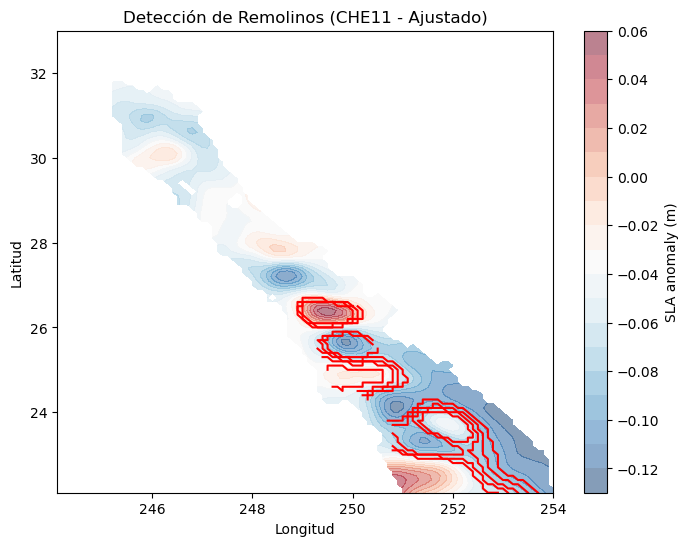

Remolino 1: Lat=23.47, Lon=252.32, Radio=1.00 km, Nivel=-0.1041
Remolino 2: Lat=23.37, Lon=252.27, Radio=0.94 km, Nivel=-0.0941
Remolino 3: Lat=23.26, Lon=251.99, Radio=0.74 km, Nivel=-0.0841
Remolino 4: Lat=25.59, Lon=249.94, Radio=0.38 km, Nivel=-0.0841
Remolino 5: Lat=22.74, Lon=252.05, Radio=0.70 km, Nivel=-0.0741


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import gaussian_filter

# -------------------------------
# Método CHE11 Ajustado para detectar más contornos
# -------------------------------
def che11_detect(sla, lon, lat, umbral_incremento=0.01, min_pixels=30, max_pixels=2500, filtro_sigma=0.5):
    """
    Método CHE11 ajustado para detectar más remolinos en el campo de SLA.

    Parámetros:
      - sla: array 2D de SLA (m).
      - lon: vector de longitudes.
      - lat: vector de latitudes.
      - umbral_incremento: incremento de SLA para evaluar niveles de contorno.
      - min_pixels: tamaño mínimo de contorno aceptable.
      - max_pixels: tamaño máximo de contorno aceptable.
      - filtro_sigma: sigma para suavizar SLA antes de encontrar contornos.
      
    Devuelve:
      - Lista de diccionarios con información de cada remolino detectado.
    """
    # Aplicar filtro Gaussiano con menor suavizado
    sla_suave = gaussian_filter(sla, sigma=filtro_sigma)

    # Definir niveles de detección más finos
    min_val, max_val = np.nanmin(sla_suave), np.nanmax(sla_suave)
    print(f"Min SLA: {min_val:.3f}, Max SLA: {max_val:.3f}")

    if np.isnan(min_val) or np.isnan(max_val):
        print("¡Advertencia! SLA contiene NaNs o valores inválidos.")
        return []

    niveles = np.arange(min_val, max_val, umbral_incremento)
    detecciones = []

    for nivel in niveles:
        # Encontrar contornos en este nivel
        contornos = measure.find_contours(sla_suave, level=nivel)

        for contorno in contornos:
            if len(contorno) < min_pixels or len(contorno) > max_pixels:
                continue  # Descartar contornos demasiado pequeños o grandes

            # Eliminar temporalmente la verificación de contornos cerrados para probar detección
            # distancia_cierre = np.linalg.norm(contorno[0] - contorno[-1])
            # if distancia_cierre > 2.5:  # Relajamos umbral de cierre
            #     continue  

            # Convertir índices de matriz a coordenadas geográficas
            longitudes = lon[contorno[:, 1].astype(int)]
            latitudes = lat[contorno[:, 0].astype(int)]

            # Calcular centroide y radio
            centroide = np.mean(np.column_stack((latitudes, longitudes)), axis=0)
            distancias = np.linalg.norm(np.column_stack((latitudes, longitudes)) - centroide, axis=1)
            radio = np.nanmean(distancias)

            detecciones.append({
                'lat': centroide[0],
                'lon': centroide[1],
                'radio': radio,
                'nivel': nivel,
                'contorno': (longitudes, latitudes)
            })

    return detecciones

# -------------------------------
# Aplicar el método CHE11 al campo de SLA del día 0
# -------------------------------
detecciones_che11 = che11_detect(sla, lon_vec, lat_vec)

# Mostrar cuántos remolinos detectó
print(f"Total de remolinos detectados: {len(detecciones_che11)}")

# -------------------------------
# Visualización mejorada de los contornos detectados
# -------------------------------
plt.figure(figsize=(8,6))
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap='RdBu_r', alpha=0.5)  # Fondo de SLA

# Graficar los contornos detectados
for det in detecciones_che11:
    lon_contorno, lat_contorno = det['contorno']
    plt.plot(lon_contorno, lat_contorno, color='red', linewidth=1.5)

plt.colorbar(label="SLA anomaly (m)")
plt.title("Detección de Remolinos (CHE11 - Ajustado)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# Mostrar los primeros 5 resultados
for i, det in enumerate(detecciones_che11[:5]):
    print(f"Remolino {i+1}: Lat={det['lat']:.2f}, Lon={det['lon']:.2f}, Radio={det['radio']:.2f} km, Nivel={det['nivel']:.4f}")


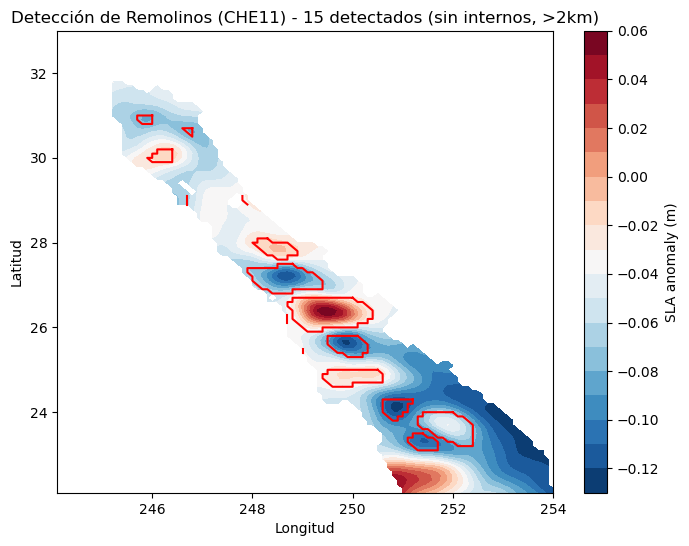

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# -------------------------------
# 1. Abrir el archivo y seleccionar el día 0
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
ds0 = ds.isel(time=0)

sla = ds0["sla_anomaly"].values
lat_vec = ds0["lat"].values
lon_vec = ds0["lon"].values

# -------------------------------
# 2. Generar los niveles de contorno de SLA
# -------------------------------
plt.figure(figsize=(8, 6))
contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
niveles_sla = contorno_figura.levels  # Extraer los niveles usados
plt.close()

# -------------------------------
# 3. Detectar contornos en SLA usando los niveles extraídos
# -------------------------------
contornos_detectados = []
for nivel in niveles_sla:
    contornos = measure.find_contours(sla, level=nivel)
    for contorno in contornos:
        x_cont, y_cont = contorno[:, 1], contorno[:, 0]
        if np.allclose(contorno[0], contorno[-1], atol=2):
            contornos_detectados.append(contorno)

# -------------------------------
# 4. Filtrar contornos internos para evitar duplicados
# -------------------------------
contornos_filtrados = []
for i, contorno_externo in enumerate(contornos_detectados):
    path_externo = Path(contorno_externo)
    es_interno = False
    for j, contorno_otro in enumerate(contornos_detectados):
        if i != j:
            path_otro = Path(contorno_otro)
            if path_otro.contains_path(path_externo):
                es_interno = True
                break
    if not es_interno:
        contornos_filtrados.append(contorno_externo)

# -------------------------------
# 5. Calcular diámetros y eliminar remolinos menores a 2 km
# -------------------------------
def calcular_diametro(contorno, lat_vec, lon_vec):
    if len(contorno) < 3:
        return 0
    hull = ConvexHull(contorno)
    latitudes = lat_vec[contorno[:, 0].astype(int)]
    longitudes = lon_vec[contorno[:, 1].astype(int)]
    distancias = [np.linalg.norm(np.array([longitudes[i], latitudes[i]]) - np.array([longitudes[j], latitudes[j]]))
                  for i in range(len(latitudes)) for j in range(i+1, len(latitudes))]
    return max(distancias) * 111  # Convertir grados a kilómetros

umbral_diametro_km = 2
contornos_finales = [c for c in contornos_filtrados if calcular_diametro(c, lat_vec, lon_vec) >= umbral_diametro_km]

# -------------------------------
# 6. Visualización de remolinos detectados filtrando internos y por diámetro
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=niveles_sla, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")

for contorno in contornos_finales:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (CHE11) - {len(contornos_finales)} detectados (sin internos, >2km)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

ds.close()



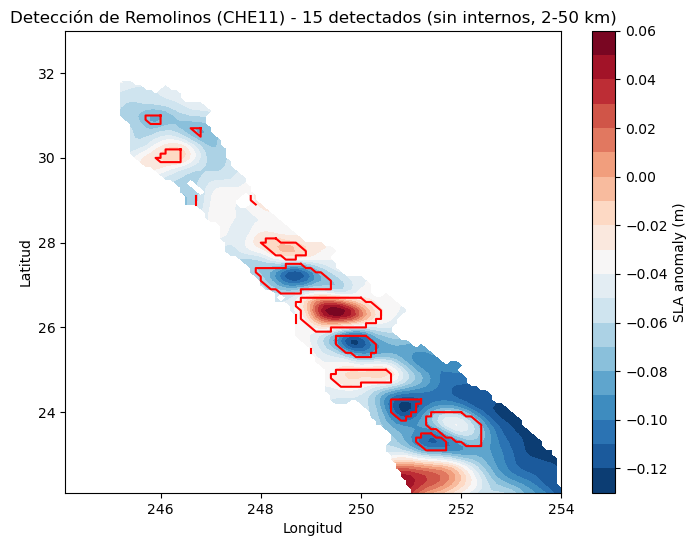

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# -------------------------------
# 1. Abrir el archivo y seleccionar el día 0
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
ds0 = ds.isel(time=0)

sla = ds0["sla_anomaly"].values
lat_vec = ds0["lat"].values
lon_vec = ds0["lon"].values

# -------------------------------
# 2. Generar los niveles de contorno de SLA
# -------------------------------
plt.figure(figsize=(8, 6))
contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
niveles_sla = contorno_figura.levels  # Extraer los niveles usados
plt.close()

# -------------------------------
# 3. Detectar contornos en SLA usando los niveles extraídos
# -------------------------------
contornos_detectados = []
for nivel in niveles_sla:
    contornos = measure.find_contours(sla, level=nivel)
    for contorno in contornos:
        x_cont, y_cont = contorno[:, 1], contorno[:, 0]
        if np.allclose(contorno[0], contorno[-1], atol=2):
            contornos_detectados.append(contorno)

# -------------------------------
# 4. Filtrar contornos internos para evitar duplicados
# -------------------------------
contornos_filtrados = []
for i, contorno_externo in enumerate(contornos_detectados):
    path_externo = Path(contorno_externo)
    es_interno = False
    for j, contorno_otro in enumerate(contornos_detectados):
        if i != j:
            path_otro = Path(contorno_otro)
            if path_otro.contains_path(path_externo):
                es_interno = True
                break
    if not es_interno:
        contornos_filtrados.append(contorno_externo)

# -------------------------------
# 5. Calcular diámetros y eliminar remolinos menores a 2 km y mayores a 50 km
# -------------------------------
def calcular_diametro(contorno, lat_vec, lon_vec):
    if len(contorno) < 3:
        return 0
    hull = ConvexHull(contorno)
    latitudes = lat_vec[contorno[:, 0].astype(int)]
    longitudes = lon_vec[contorno[:, 1].astype(int)]
    distancias = [np.linalg.norm(np.array([longitudes[i], latitudes[i]]) - np.array([longitudes[j], latitudes[j]]))
                  for i in range(len(latitudes)) for j in range(i+1, len(latitudes))]
    return max(distancias) * 111  # Convertir grados a kilómetros

umbral_diametro_min_km = 10
umbral_diametro_max_km = 500
contornos_finales_che11 = [c for c in contornos_filtrados if umbral_diametro_min_km <= calcular_diametro(c, lat_vec, lon_vec) <= umbral_diametro_max_km]

# -------------------------------
# 6. Visualización de remolinos detectados filtrando internos y por diámetro
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=niveles_sla, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")

for contorno in contornos_finales_che11:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (CHE11) - {len(contornos_finales_che11)} detectados (sin internos, 2-50 km)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

ds.close()


C:\Users\Segunda El Dago\AppData\Local\Temp\ipykernel_21360\1877328261.py:85: RuntimeWarning: Mean of empty slice
  if np.nanmean(okubo_weiss[indices_y, indices_x]) < umbral_ow:


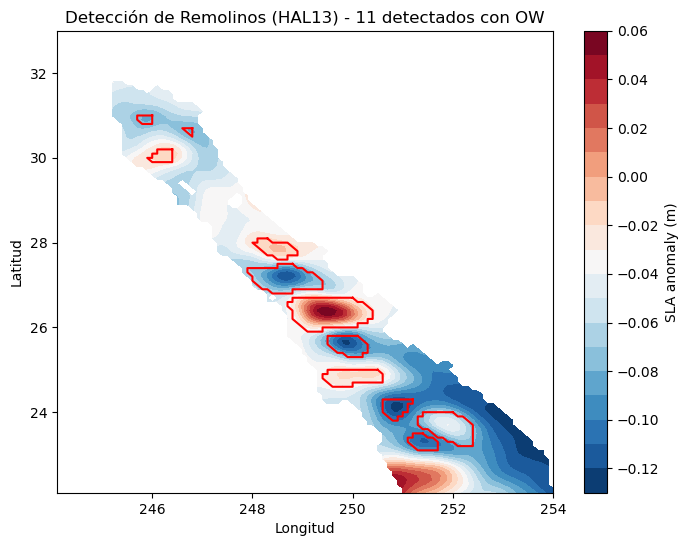

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# -------------------------------
# 1. Abrir el archivo y seleccionar el día 0
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
ds0 = ds.isel(time=0)

sla = ds0["sla_anomaly"].values
lat_vec = ds0["lat"].values
lon_vec = ds0["lon"].values

# -------------------------------
# 2. Calcular Okubo-Weiss
# -------------------------------
def calcular_okubo_weiss(sla, lat, lon, g=9.81):
    Omega = 7.2921e-5
    lat_mean = np.mean(lat)
    f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
    dx = np.gradient(lon) * 111320  # Aproximación en metros
    dy = np.gradient(lat)[:, np.newaxis] * 111320
    dSLA_dx = np.gradient(sla, axis=1) / dx
    dSLA_dy = np.gradient(sla, axis=0) / dy
    ugos = - (g / f) * dSLA_dy
    vgos = (g / f) * dSLA_dx
    du_dx = np.gradient(ugos, axis=1) / dx
    du_dy = np.gradient(ugos, axis=0) / dy
    dv_dx = np.gradient(vgos, axis=1) / dx
    dv_dy = np.gradient(vgos, axis=0) / dy
    Sn = du_dx - dv_dy
    Ss = du_dy + dv_dx
    zeta = dv_dx - du_dy
    W = Sn**2 + Ss**2 - zeta**2
    return W

okubo_weiss = calcular_okubo_weiss(sla, lat_vec, lon_vec)

# -------------------------------
# 3. Generar los niveles de contorno de SLA
# -------------------------------
plt.figure(figsize=(8, 6))
contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
niveles_sla = contorno_figura.levels  # Extraer los niveles usados
plt.close()

# -------------------------------
# 4. Detectar contornos en SLA usando los niveles extraídos
# -------------------------------
contornos_detectados = []
for nivel in niveles_sla:
    contornos = measure.find_contours(sla, level=nivel)
    for contorno in contornos:
        x_cont, y_cont = contorno[:, 1], contorno[:, 0]
        if np.allclose(contorno[0], contorno[-1], atol=2):
            contornos_detectados.append(contorno)

# -------------------------------
# 5. Filtrar contornos internos y aplicar criterio de Okubo-Weiss
# -------------------------------
contornos_filtrados = []
for i, contorno_externo in enumerate(contornos_detectados):
    path_externo = Path(contorno_externo)
    es_interno = False
    for j, contorno_otro in enumerate(contornos_detectados):
        if i != j:
            path_otro = Path(contorno_otro)
            if path_otro.contains_path(path_externo):
                es_interno = True
                break
    if not es_interno:
        contornos_filtrados.append(contorno_externo)

# Aplicar criterio de Okubo-Weiss (OW < -0.2 indica remolino bien definido)
contornos_finales_hal13 = []
umbral_ow = 2
for contorno in contornos_filtrados:
    indices_x = contorno[:, 1].astype(int)
    indices_y = contorno[:, 0].astype(int)
    if np.nanmean(okubo_weiss[indices_y, indices_x]) < umbral_ow:
        contornos_finales_hal13.append(contorno)

# -------------------------------
# 6. Visualización de remolinos detectados con OW
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=niveles_sla, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")

for contorno in contornos_finales_hal13:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (HAL13) - {len(contornos_finales_hal13)} detectados con OW")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

ds.close()



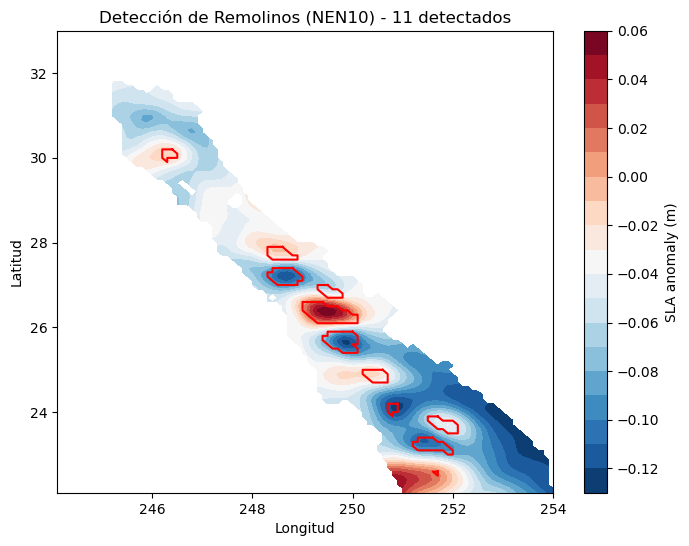

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# -------------------------------
# 1. Abrir el archivo y seleccionar el día 0
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
ds0 = ds.isel(time=0)

sla = ds0["sla_anomaly"].values
lat_vec = ds0["lat"].values
lon_vec = ds0["lon"].values

# -------------------------------
# 2. Calcular las velocidades geostróficas
# -------------------------------
def calcular_velocidades_geostroficas(sla, lat, lon, g=9.81):
    Omega = 7.2921e-5
    lat_mean = np.mean(lat)
    f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
    dx = np.gradient(lon) * 111320
    dy = np.gradient(lat)[:, np.newaxis] * 111320
    dSLA_dx = np.gradient(sla, axis=1) / dx
    dSLA_dy = np.gradient(sla, axis=0) / dy
    ugos = - (g / f) * dSLA_dy
    vgos = (g / f) * dSLA_dx
    return ugos, vgos

ugos, vgos = calcular_velocidades_geostroficas(sla, lat_vec, lon_vec)

# -------------------------------
# 3. Identificación de remolinos por geometría de velocidades
# -------------------------------
def detectar_remolinos_por_velocidad(ugos, vgos, lon, lat):
    vorticidad = np.gradient(vgos, axis=1) - np.gradient(ugos, axis=0)
    umbral_vorticidad = np.nanpercentile(np.abs(vorticidad), 90)
    mascara_remolinos = np.abs(vorticidad) > umbral_vorticidad
    return mascara_remolinos

mascara_remolinos = detectar_remolinos_por_velocidad(ugos, vgos, lon_vec, lat_vec)

# -------------------------------
# 4. Detectar contornos de remolinos
# -------------------------------
contornos_detectados = measure.find_contours(mascara_remolinos, level=0.5)

# -------------------------------
# 5. Filtrar contornos internos para evitar duplicados
# -------------------------------
contornos_finales_nen10 = []
for i, contorno_externo in enumerate(contornos_detectados):
    path_externo = Path(contorno_externo)
    es_interno = False
    for j, contorno_otro in enumerate(contornos_detectados):
        if i != j:
            path_otro = Path(contorno_otro)
            if path_otro.contains_path(path_externo):
                es_interno = True
                break
    if not es_interno:
        contornos_finales_nen10.append(contorno_externo)

# -------------------------------
# 6. Visualización de remolinos detectados
# -------------------------------
plt.figure(figsize=(8, 6))
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")

for contorno in contornos_finales_nen10:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)

plt.title(f"Detección de Remolinos (NEN10) - {len(contornos_finales_nen10)} detectados")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

ds.close()


In [11]:
import matplotlib.pyplot as plt

# Definir listas de remolinos a partir de los contornos
remolinos_che11 = [{'contorno': c} for c in contornos_finales_che11]
remolinos_hal13 = [{'contorno': c} for c in contornos_finales_hal13]
remolinos_nen10 = [{'contorno': c} for c in contornos_finales_nen10]


# -------------------------------
# Variables de contornos desde cada método
# -------------------------------
from remolinos_che11 import contornos_finales as contornos_finales_che11
from remolinos_hal13 import contornos_finales as contornos_finales_hal13
from remolinos_nen10 import contornos_finales as contornos_finales_nen10

# -------------------------------
# Comparación de los tres métodos en un solo gráfico
# -------------------------------
plt.figure(figsize=(15, 5))

# CHE11
plt.subplot(1, 3, 1)
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")
for contorno in contornos_finales_che11:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
plt.title(f"CHE11 - {len(contornos_finales_che11)} remolinos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

# HAL13
plt.subplot(1, 3, 2)
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")
for contorno in contornos_finales_hal13:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
plt.title(f"HAL13 - {len(contornos_finales_hal13)} remolinos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

# NEN10
plt.subplot(1, 3, 3)
plt.contourf(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
plt.colorbar(label="SLA anomaly (m)")
for contorno in contornos_finales_nen10:
    plt.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
plt.title(f"NEN10 - {len(contornos_finales_nen10)} remolinos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'remolinos_che11'

In [12]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from skimage import measure
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# -------------------------------
# Cargar datos
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
lat_vec = ds["lat"].values
lon_vec = ds["lon"].values
sla = ds["sla_anomaly"].isel(time=0).values

# -------------------------------
# Función de detección CHE11
# -------------------------------
def detectar_che11(sla, lat_vec, lon_vec):
    """ Método CHE11: Contornos cerrados de SLA con filtrado por tamaño """
    plt.figure(figsize=(8, 6))
    contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
    niveles_sla = contorno_figura.levels
    plt.close()
    
    contornos_detectados = []
    for nivel in niveles_sla:
        contornos = measure.find_contours(sla, level=nivel)
        for contorno in contornos:
            if np.allclose(contorno[0], contorno[-1], atol=2):
                contornos_detectados.append(contorno)
    
    # Filtrar contornos internos
    contornos_filtrados = []
    for i, contorno_externo in enumerate(contornos_detectados):
        path_externo = Path(contorno_externo)
        es_interno = False
        for j, contorno_otro in enumerate(contornos_detectados):
            if i != j:
                path_otro = Path(contorno_otro)
                if path_otro.contains_path(path_externo):
                    es_interno = True
                    break
        if not es_interno:
            contornos_filtrados.append(contorno_externo)
    
    # Filtrar por diámetro
    def calcular_diametro(contorno, lat_vec, lon_vec):
        if len(contorno) < 3:
            return 0
        hull = ConvexHull(contorno)
        latitudes = lat_vec[contorno[:, 0].astype(int)]
        longitudes = lon_vec[contorno[:, 1].astype(int)]
        distancias = [np.linalg.norm(np.array([longitudes[i], latitudes[i]]) - np.array([longitudes[j], latitudes[j]]))
                      for i in range(len(latitudes)) for j in range(i+1, len(latitudes))]
        return max(distancias) * 111  # Convertir grados a kilómetros
    
    umbral_diametro_min_km = 10
    umbral_diametro_max_km = 500
    contornos_finales = [c for c in contornos_filtrados if umbral_diametro_min_km <= calcular_diametro(c, lat_vec, lon_vec) <= umbral_diametro_max_km]
    
    return contornos_finales

# -------------------------------
# Función de detección HAL13
# -------------------------------
def detectar_hal13(contornos_che11, sla, lat_vec, lon_vec):
    """ Método HAL13: Aplica Okubo-Weiss a los contornos de CHE11 """
    def calcular_okubo_weiss(sla, lat, lon, g=9.81):
        Omega = 7.2921e-5
        lat_mean = np.mean(lat)
        f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
        dx = np.gradient(lon) * 111320  # Aproximación en metros
        dy = np.gradient(lat)[:, np.newaxis] * 111320
        dSLA_dx = np.gradient(sla, axis=1) / dx
        dSLA_dy = np.gradient(sla, axis=0) / dy
        ugos = - (g / f) * dSLA_dy
        vgos = (g / f) * dSLA_dx
        du_dx = np.gradient(ugos, axis=1) / dx
        du_dy = np.gradient(ugos, axis=0) / dy
        dv_dx = np.gradient(vgos, axis=1) / dx
        dv_dy = np.gradient(vgos, axis=0) / dy
        Sn = du_dx - dv_dy
        Ss = du_dy + dv_dx
        zeta = dv_dx - du_dy
        W = Sn**2 + Ss**2 - zeta**2
        return W
    
    W = calcular_okubo_weiss(sla, lat_vec, lon_vec)
    contornos_finales = []
    umbral_ow = -0  # Umbral para identificar remolinos
    
    for contorno in contornos_che11:
        indices_x = contorno[:, 1].astype(int)
        indices_y = contorno[:, 0].astype(int)
        if np.nanmean(W[indices_y, indices_x]) < umbral_ow:
            contornos_finales.append(contorno)
    
    return contornos_finales

# -------------------------------
# Función de detección NEN10
# -------------------------------
def detectar_nen10(sla, lat_vec, lon_vec):
    """ Método NEN10: Identificación de remolinos por geometría de velocidades """
    def calcular_velocidades_geostroficas(sla, lat, lon, g=9.81):
        Omega = 7.2921e-5
        lat_mean = np.mean(lat)
        f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
        dx = np.gradient(lon) * 111320
        dy = np.gradient(lat)[:, np.newaxis] * 111320
        dSLA_dx = np.gradient(sla, axis=1) / dx
        dSLA_dy = np.gradient(sla, axis=0) / dy
        ugos = - (g / f) * dSLA_dy
        vgos = (g / f) * dSLA_dx
        return ugos, vgos
    
    ugos, vgos = calcular_velocidades_geostroficas(sla, lat_vec, lon_vec)
    vorticidad = np.gradient(vgos, axis=1) - np.gradient(ugos, axis=0)
    umbral_vorticidad = np.nanpercentile(np.abs(vorticidad), 90)
    mascara_remolinos = np.abs(vorticidad) > umbral_vorticidad
    contornos_detectados = measure.find_contours(mascara_remolinos.astype(float), level=0.5)
    
    # Filtrar contornos internos
    contornos_finales = []
    for i, contorno_externo in enumerate(contornos_detectados):
        path_externo = Path(contorno_externo)
        es_interno = False
        for j, contorno_otro in enumerate(contornos_detectados):
            if i != j:
                path_otro = Path(contorno_otro)
                if path_otro.contains_path(path_externo):
                    es_interno = True
                    break
        if not es_interno:
            contornos_finales.append(contorno_externo)
    
    return contornos_finales

# -------------------------------
# Aplicar métodos de detección
# -------------------------------
contornos_che11 = detectar_che11(sla, lat_vec, lon_vec)
contornos_hal13 = detectar_hal13(contornos_che11, sla, lat_vec, lon_vec)
contornos_nen10 = detectar_nen10(sla, lat_vec, lon_vec)


C:\Users\Segunda El Dago\AppData\Local\Temp\ipykernel_21360\1663430775.py:97: RuntimeWarning: Mean of empty slice
  if np.nanmean(W[indices_y, indices_x]) < umbral_ow:


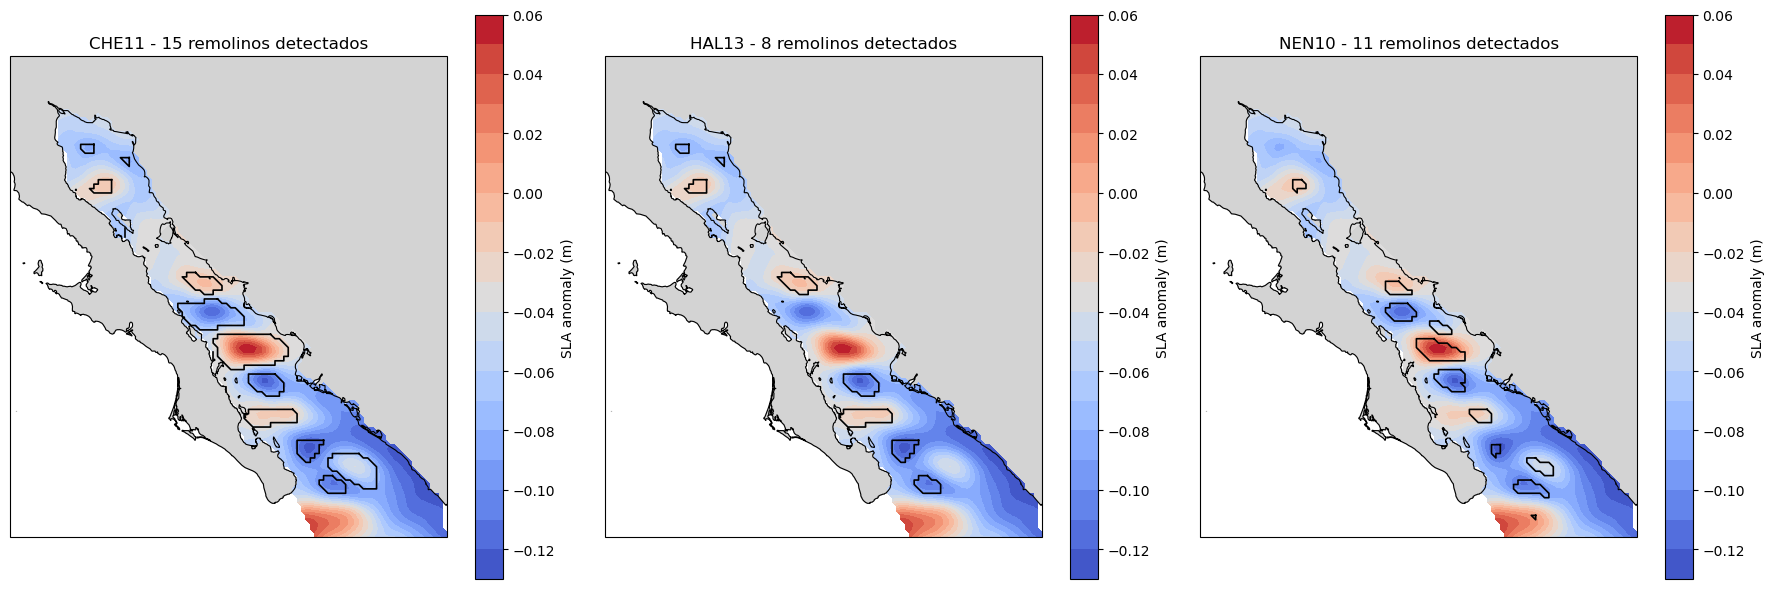

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------------------
# Comparación de los tres métodos en un solo gráfico (Corrección para mostrar SLA)
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# CHE11
ax = axes[0]
ax.set_title(f"CHE11 - {len(contornos_che11)} remolinos detectados")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
contour = ax.contourf(lon_vec, lat_vec, sla, levels=20, cmap="coolwarm", transform=ccrs.PlateCarree())
fig.colorbar(contour, ax=ax, label="SLA anomaly (m)")
for contorno in contornos_che11:
    ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'k', linewidth=1.2, transform=ccrs.PlateCarree())

# HAL13
ax = axes[1]
ax.set_title(f"HAL13 - {len(contornos_hal13)} remolinos detectados")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
contour = ax.contourf(lon_vec, lat_vec, sla, levels=20, cmap="coolwarm", transform=ccrs.PlateCarree())
fig.colorbar(contour, ax=ax, label="SLA anomaly (m)")
for contorno in contornos_hal13:
    ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'k', linewidth=1.2, transform=ccrs.PlateCarree())

# NEN10
ax = axes[2]
ax.set_title(f"NEN10 - {len(contornos_nen10)} remolinos detectados")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
contour = ax.contourf(lon_vec, lat_vec, sla, levels=20, cmap="coolwarm", transform=ccrs.PlateCarree())
fig.colorbar(contour, ax=ax, label="SLA anomaly (m)")
for contorno in contornos_nen10:
    ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'k', linewidth=1.2, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

ds.close()


In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from skimage import measure
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# -------------------------------
# Cargar datos
# -------------------------------
archivo = r"anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
lat_vec = ds["lat"].values
lon_vec = ds["lon"].values
sla = ds["sla_anomaly"].values


# -------------------------------
# Función de detección CHE11
# -------------------------------
def detectar_che11(sla, lat_vec, lon_vec):
    """ Método CHE11: Contornos cerrados de SLA con filtrado por tamaño """
    plt.figure(figsize=(8, 6))
    contorno_figura = plt.contour(lon_vec, lat_vec, sla, levels=20, cmap="RdBu_r")
    niveles_sla = contorno_figura.levels
    plt.close()
    
    contornos_detectados = []
    for nivel in niveles_sla:
        contornos = measure.find_contours(sla, level=nivel)
        for contorno in contornos:
            if np.allclose(contorno[0], contorno[-1], atol=2):
                contornos_detectados.append(contorno)
    
    # Filtrar contornos internos
    contornos_filtrados = []
    for i, contorno_externo in enumerate(contornos_detectados):
        path_externo = Path(contorno_externo)
        es_interno = False
        for j, contorno_otro in enumerate(contornos_detectados):
            if i != j:
                path_otro = Path(contorno_otro)
                if path_otro.contains_path(path_externo):
                    es_interno = True
                    break
        if not es_interno:
            contornos_filtrados.append(contorno_externo)
    
    # Filtrar por diámetro
    def calcular_diametro(contorno, lat_vec, lon_vec):
        if len(contorno) < 3:
            return 0
        hull = ConvexHull(contorno)
        latitudes = lat_vec[contorno[:, 0].astype(int)]
        longitudes = lon_vec[contorno[:, 1].astype(int)]
        distancias = [np.linalg.norm(np.array([longitudes[i], latitudes[i]]) - np.array([longitudes[j], latitudes[j]]))
                      for i in range(len(latitudes)) for j in range(i+1, len(latitudes))]
        return max(distancias) * 111  # Convertir grados a kilómetros
    
    umbral_diametro_min_km = 10
    umbral_diametro_max_km = 500
    contornos_finales = [c for c in contornos_filtrados if umbral_diametro_min_km <= calcular_diametro(c, lat_vec, lon_vec) <= umbral_diametro_max_km]
    
    return contornos_finales

# -------------------------------
# Función de detección HAL13
# -------------------------------
def detectar_hal13(contornos_che11, sla, lat_vec, lon_vec):
    """ Método HAL13: Aplica Okubo-Weiss a los contornos de CHE11 """
    def calcular_okubo_weiss(sla, lat, lon, g=9.81):
        Omega = 7.2921e-5
        lat_mean = np.mean(lat)
        f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
        dx = np.gradient(lon) * 111320  # Aproximación en metros
        dy = np.gradient(lat)[:, np.newaxis] * 111320
        dSLA_dx = np.gradient(sla, axis=1) / dx
        dSLA_dy = np.gradient(sla, axis=0) / dy
        ugos = - (g / f) * dSLA_dy
        vgos = (g / f) * dSLA_dx
        du_dx = np.gradient(ugos, axis=1) / dx
        du_dy = np.gradient(ugos, axis=0) / dy
        dv_dx = np.gradient(vgos, axis=1) / dx
        dv_dy = np.gradient(vgos, axis=0) / dy
        Sn = du_dx - dv_dy
        Ss = du_dy + dv_dx
        zeta = dv_dx - du_dy
        W = Sn**2 + Ss**2 - zeta**2
        return W
    
    W = calcular_okubo_weiss(sla, lat_vec, lon_vec)
    contornos_finales = []
    umbral_ow = -0  # Umbral para identificar remolinos
    
    for contorno in contornos_che11:
        indices_x = contorno[:, 1].astype(int)
        indices_y = contorno[:, 0].astype(int)
        if np.nanmean(W[indices_y, indices_x]) < umbral_ow:
            contornos_finales.append(contorno)
    
    return contornos_finales

# -------------------------------
# Función de detección NEN10
# -------------------------------
def detectar_nen10(sla, lat_vec, lon_vec):
    """ Método NEN10: Identificación de remolinos por geometría de velocidades """
    def calcular_velocidades_geostroficas(sla, lat, lon, g=9.81):
        Omega = 7.2921e-5
        lat_mean = np.mean(lat)
        f = 2 * Omega * np.sin(np.deg2rad(lat_mean))
        dx = np.gradient(lon) * 111320
        dy = np.gradient(lat)[:, np.newaxis] * 111320
        dSLA_dx = np.gradient(sla, axis=1) / dx
        dSLA_dy = np.gradient(sla, axis=0) / dy
        ugos = - (g / f) * dSLA_dy
        vgos = (g / f) * dSLA_dx
        return ugos, vgos
    
    ugos, vgos = calcular_velocidades_geostroficas(sla, lat_vec, lon_vec)
    vorticidad = np.gradient(vgos, axis=1) - np.gradient(ugos, axis=0)
    umbral_vorticidad = np.nanpercentile(np.abs(vorticidad), 90)
    mascara_remolinos = np.abs(vorticidad) > umbral_vorticidad
    contornos_detectados = measure.find_contours(mascara_remolinos.astype(float), level=0.5)
    
    # Filtrar contornos internos
    contornos_finales = []
    for i, contorno_externo in enumerate(contornos_detectados):
        path_externo = Path(contorno_externo)
        es_interno = False
        for j, contorno_otro in enumerate(contornos_detectados):
            if i != j:
                path_otro = Path(contorno_otro)
                if path_otro.contains_path(path_externo):
                    es_interno = True
                    break
        if not es_interno:
            contornos_finales.append(contorno_externo)
    
    return contornos_finales

# -------------------------------
# Aplicar métodos de detección día a día
# -------------------------------
contornos_che11_tiempo = []
contornos_hal13_tiempo = []
contornos_nen10_tiempo = []

for i in range(sla.shape[0]):
    print(f"Procesando día {i}...")
    contornos_che11 = detectar_che11(sla[i], lat_vec, lon_vec)
    contornos_hal13 = detectar_hal13(contornos_che11, sla[i], lat_vec, lon_vec)
    contornos_nen10 = detectar_nen10(sla[i], lat_vec, lon_vec)
    
    contornos_che11_tiempo.append(contornos_che11)
    contornos_hal13_tiempo.append(contornos_hal13)
    contornos_nen10_tiempo.append(contornos_nen10)


Procesando día 0...


C:\Users\Segunda El Dago\AppData\Local\Temp\ipykernel_16124\3670999352.py:98: RuntimeWarning: Mean of empty slice
  if np.nanmean(W[indices_y, indices_x]) < umbral_ow:


Procesando día 1...
Procesando día 2...
Procesando día 3...
Procesando día 4...
Procesando día 5...
Procesando día 6...
Procesando día 7...
Procesando día 8...
Procesando día 9...
Procesando día 10...
Procesando día 11...
Procesando día 12...
Procesando día 13...
Procesando día 14...
Procesando día 15...
Procesando día 16...
Procesando día 17...
Procesando día 18...
Procesando día 19...
Procesando día 20...
Procesando día 21...
Procesando día 22...
Procesando día 23...
Procesando día 24...
Procesando día 25...
Procesando día 26...
Procesando día 27...
Procesando día 28...
Procesando día 29...
Procesando día 30...
Procesando día 31...
Procesando día 32...
Procesando día 33...
Procesando día 34...
Procesando día 35...
Procesando día 36...
Procesando día 37...
Procesando día 38...
Procesando día 39...
Procesando día 40...
Procesando día 41...
Procesando día 42...
Procesando día 43...
Procesando día 44...
Procesando día 45...
Procesando día 46...
Procesando día 47...
Procesando día 48...
P

Procesando día 381...
Procesando día 382...
Procesando día 383...
Procesando día 384...
Procesando día 385...
Procesando día 386...
Procesando día 387...
Procesando día 388...
Procesando día 389...
Procesando día 390...
Procesando día 391...
Procesando día 392...
Procesando día 393...
Procesando día 394...
Procesando día 395...
Procesando día 396...
Procesando día 397...
Procesando día 398...
Procesando día 399...
Procesando día 400...
Procesando día 401...
Procesando día 402...
Procesando día 403...
Procesando día 404...
Procesando día 405...
Procesando día 406...
Procesando día 407...
Procesando día 408...
Procesando día 409...
Procesando día 410...
Procesando día 411...
Procesando día 412...
Procesando día 413...
Procesando día 414...
Procesando día 415...
Procesando día 416...
Procesando día 417...
Procesando día 418...
Procesando día 419...
Procesando día 420...
Procesando día 421...
Procesando día 422...
Procesando día 423...
Procesando día 424...
Procesando día 425...
Procesando

Procesando día 755...
Procesando día 756...
Procesando día 757...
Procesando día 758...
Procesando día 759...
Procesando día 760...
Procesando día 761...
Procesando día 762...
Procesando día 763...
Procesando día 764...
Procesando día 765...
Procesando día 766...
Procesando día 767...
Procesando día 768...
Procesando día 769...
Procesando día 770...
Procesando día 771...
Procesando día 772...
Procesando día 773...
Procesando día 774...
Procesando día 775...
Procesando día 776...
Procesando día 777...
Procesando día 778...
Procesando día 779...
Procesando día 780...
Procesando día 781...
Procesando día 782...
Procesando día 783...
Procesando día 784...
Procesando día 785...
Procesando día 786...
Procesando día 787...
Procesando día 788...
Procesando día 789...
Procesando día 790...
Procesando día 791...
Procesando día 792...
Procesando día 793...
Procesando día 794...
Procesando día 795...
Procesando día 796...
Procesando día 797...
Procesando día 798...
Procesando día 799...
Procesando

Animation size has reached 21002888 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


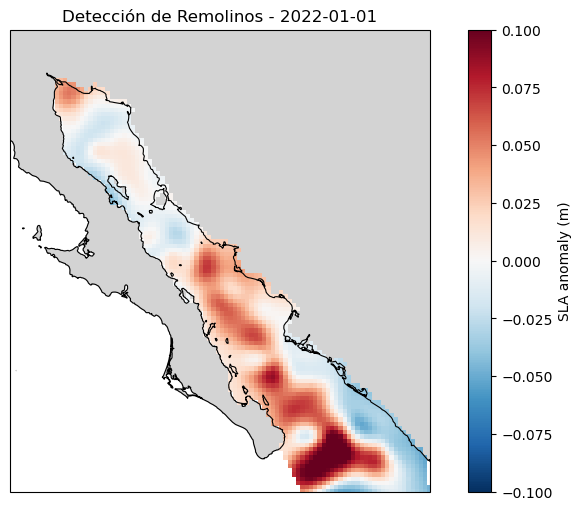

In [19]:
import matplotlib.animation as animation


time = ds["time"].values

# -------------------------------
# Crear animación con pcolormesh
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

img = ax.pcolormesh(lon_vec, lat_vec, sla[0], cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='SLA anomaly (m)')

def update(frame):
    img.set_array(sla[frame].flatten())  # Actualiza los datos de pcolormesh
    img.set_clim(sla.min(), sla.max())  # Ajusta el rango de colores dinámicamente
    ax.set_title(f"Detección de Remolinos - {np.datetime_as_string(time[frame], unit='D')}")
    
    # Limpiar contornos anteriores antes de dibujar los nuevos
    for coll in ax.collections[1:]:
        coll.remove()
    
    for contorno in contornos_che11_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
    for contorno in contornos_hal13_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'b', linewidth=1.5)
    for contorno in contornos_nen10_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'g', linewidth=1.5)
    
    return img,

ani = animation.FuncAnimation(fig, update, frames=sla.shape[0], interval=200, blit=False)

# Para Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

# Para guardar como video
# ani.save("animacion_remolinos.mp4", writer="ffmpeg", fps=5)

plt.show()
ds.close()


In [ ]:
# -------------------------------
# Visualización de resultados para múltiples tiempos
# -------------------------------
for t in range(sla.shape[0]):
    plt.figure(figsize=(12, 6))
    plt.contourf(lon_vec, lat_vec, sla[t], levels=20, cmap="RdBu_r")
    plt.colorbar(label="SLA anomaly (m)")
    
    for contorno in contornos_che11_tiempo[t]:
        plt.plot(contorno[:, 1], contorno[:, 0], 'r', linewidth=1.5, label="CHE11")
    for contorno in contornos_hal13_tiempo[t]:
        plt.plot(contorno[:, 1], contorno[:, 0], 'b', linewidth=1.5, label="HAL13")
    for contorno in contornos_nen10_tiempo[t]:
        plt.plot(contorno[:, 1], contorno[:, 0], 'g', linewidth=1.5, label="NEN10")
    
    plt.title(f"Detección de Remolinos - Día {t}")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.show()

ds.close()

In [ ]:
import matplotlib.animation as animation

# -------------------------------
# Crear animación con mapa
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

contour = ax.contourf(lon_vec, lat_vec, sla[0], levels=20, cmap="RdBu_r", transform=ccrs.PlateCarree())
contornos_che11_plot, = ax.plot([], [], 'r', linewidth=1.5, label="CHE11")
contornos_hal13_plot, = ax.plot([], [], 'b', linewidth=1.5, label="HAL13")
contornos_nen10_plot, = ax.plot([], [], 'g', linewidth=1.5, label="NEN10")

def update(frame):
    ax.clear()
    ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    
    ax.contourf(lon_vec, lat_vec, sla[frame], levels=20, cmap="RdBu_r", transform=ccrs.PlateCarree())
    
    for contorno in contornos_che11_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
    for contorno in contornos_hal13_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'b', linewidth=1.5)
    for contorno in contornos_nen10_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'g', linewidth=1.5)
    
    ax.set_title(f"Detección de Remolinos - {np.datetime_as_string(tiempo[frame], unit='D')}")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.legend()

ani = animation.FuncAnimation(fig, update, frames=sla.shape[0], repeat=True)
plt.show()

ds.close()

In [ ]:
# -------------------------------
# Crear animación con pcolormesh
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

img = ax.pcolormesh(lon_vec, lat_vec, sla[0], cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='SLA anomaly (m)')

def update(frame):
    current_sla = sla[frame]
    img.set_array(current_sla.flatten())
    ax.set_title(f"Detección de Remolinos - {np.datetime_as_string(tiempo[frame], unit='D')}")
    
    for contorno in contornos_che11_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
    for contorno in contornos_hal13_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'b', linewidth=1.5)
    for contorno in contornos_nen10_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'g', linewidth=1.5)

ani = animation.FuncAnimation(fig, update, frames=sla.shape[0], interval=200, blit=False)

plt.show()
ds.close()

In [ ]:
# -------------------------------
# Crear animación con pcolormesh
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_vec.min(), lon_vec.max(), lat_vec.min(), lat_vec.max()])
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

img = ax.pcolormesh(lon_vec, lat_vec, sla[0], cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())
cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='SLA anomaly (m)')

def update(frame):
    img.set_array(sla[frame].ravel())  # Actualiza los datos de pcolormesh
    img.set_clim(sla.min(), sla.max())  # Ajusta el rango de colores dinámicamente
    ax.set_title(f"Detección de Remolinos - {np.datetime_as_string(tiempo[frame], unit='D')}")
    
    # Limpiar contornos anteriores antes de dibujar los nuevos
    while len(ax.collections) > 1:
        ax.collections.pop()
    
    for contorno in contornos_che11_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'r', linewidth=1.5)
    for contorno in contornos_hal13_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'b', linewidth=1.5)
    for contorno in contornos_nen10_tiempo[frame]:
        ax.plot(lon_vec[contorno[:, 1].astype(int)], lat_vec[contorno[:, 0].astype(int)], 'g', linewidth=1.5)
    
    return img,

ani = animation.FuncAnimation(fig, update, frames=sla.shape[0], interval=200, blit=False)

# Para Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

# Para guardar como video
# ani.save("animacion_remolinos.mp4", writer="ffmpeg", fps=5)

plt.show()
ds.close()

In [26]:
import xarray as xr
import numpy as np

# -------------------------------
# Funciones para el cálculo de variables oceánicas
# -------------------------------

def calcular_velocidades_geostroficas(sla, lat, lon, g=9.81):
    """
    Calcula las velocidades geostróficas u y v a partir del campo de SLA.
    
    u = - (g / f) * dη/dy  
    v =   (g / f) * dη/dx
    
    Parámetros:
      - sla: array 2D de SLA (m) con forma (lat, lon).
      - lat: vector de latitudes (grados).
      - lon: vector de longitudes (grados).
      - g: aceleración de la gravedad (m/s²).
      
    Devuelve:
      - u, v: arrays 2D de velocidades geostróficas (m/s).
    """
    Omega = 7.2921e-5  # rotación de la Tierra en rad/s
    f = 2 * Omega * np.sin(np.deg2rad(lat))[:, None]  # Se calcula f para cada latitud

    # Convertir grados a metros (manteniendo distancias como 1D)
    R = 6371e3  # Radio de la Tierra en metros
    dx = np.gradient(lon) * (np.pi / 180) * R * np.cos(np.deg2rad(np.mean(lat)))  # 1D
    dy = np.gradient(lat) * (np.pi / 180) * R  # 1D

    # Gradientes espaciales de SLA
    dSLA_dy = np.gradient(sla, axis=0) / dy[:, None]
    dSLA_dx = np.gradient(sla, axis=1) / dx[None, :]

    # Cálculo de velocidades
    u = - (g / f) * dSLA_dy
    v = (g / f) * dSLA_dx

    return u, v

def calcular_vorticidad(u, v, dx, dy):
    """
    Calcula la vorticidad relativa ζ = dv/dx - du/dy.
    
    Parámetros:
      - u: velocidad geostrófica zonal (m/s).
      - v: velocidad geostrófica meridional (m/s).
      - dx, dy: espaciamientos en metros (1D).
      
    Devuelve:
      - zeta: vorticidad relativa (1/s).
    """
    du_dy = np.gradient(u, axis=0) / dy[:, None]
    dv_dx = np.gradient(v, axis=1) / dx[None, :]
    zeta = dv_dx - du_dy
    return zeta

def calcular_okubo_weiss(u, v, dx, dy):
    """
    Calcula el parámetro de Okubo-Weiss (W) a partir de u y v.
    
    Parámetros:
      - u: velocidad geostrófica zonal (m/s).
      - v: velocidad geostrófica meridional (m/s).
      - dx, dy: espaciamientos en metros (1D).
      
    Devuelve:
      - W: parámetro de Okubo-Weiss.
    """
    du_dx = np.gradient(u, axis=1) / dx[None, :]
    du_dy = np.gradient(u, axis=0) / dy[:, None]
    dv_dx = np.gradient(v, axis=1) / dx[None, :]
    dv_dy = np.gradient(v, axis=0) / dy[:, None]

    Sn = du_dx - dv_dy  # Cizalla normal
    Ss = du_dy + dv_dx  # Cizalla de cizallamiento
    zeta = dv_dx - du_dy  # Vorticidad relativa

    W = Sn**2 + Ss**2 - zeta**2
    return W

# -------------------------------
# Cargar el archivo NetCDF y seleccionar un instante de tiempo
# -------------------------------
archivo = "anomalia_SLA_GC_NeurOST.nc"
ds = xr.open_dataset(archivo)
ds0 = ds.isel(time=0)  # Seleccionar el primer día

# Extraer datos
sla = ds0["sla_anomaly"].values  # Campo SLA (lat, lon)
lat = ds0["lat"].values       # Latitudes
lon = ds0["lon"].values       # Longitudes

# -------------------------------
# Cálculo de variables físicas
# -------------------------------
u, v = calcular_velocidades_geostroficas(sla, lat_vec, lon_vec)
zeta = calcular_vorticidad(u, v, dx=np.gradient(lon), dy=np.gradient(lat))
W = calcular_okubo_weiss(u, v, dx=np.gradient(lon), dy=np.gradient(lat))

# -------------------------------
# Guardar resultados en NetCDF
# -------------------------------
ds_result = xr.Dataset(
    {
        "vorticidad_relativa": (["lat", "lon"], zeta),
        "okubo_weiss": (["lat", "lon"], W),
        "u_geostrofico": (["lat", "lon"], u),
        "v_geostrofico": (["lat", "lon"], v),
    },
    coords={"lat": lat_vec, "lon": lon_vec},
)

# Guardar en un nuevo archivo
output_file = "datos_procesados_remolinos.nc"
ds_result.to_netcdf(output_file)

print(f"Archivo guardado: {output_file}")


Archivo guardado: datos_procesados_remolinos.nc


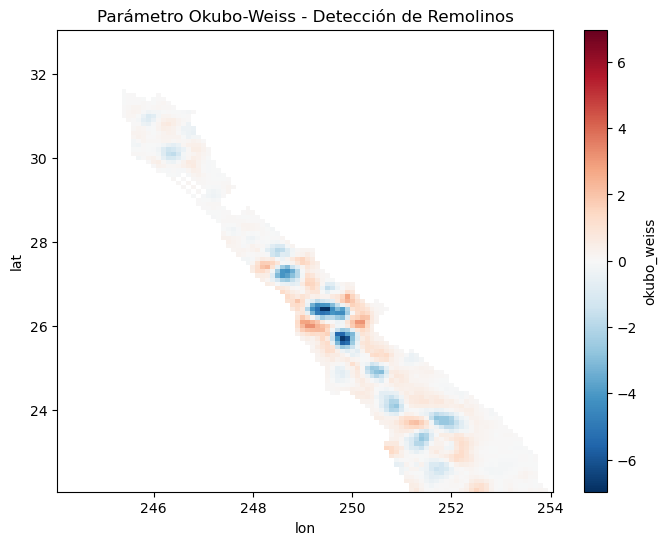

In [27]:
import matplotlib.pyplot as plt

ds_res = xr.open_dataset("datos_procesados_remolinos.nc")

plt.figure(figsize=(8,6))
ds_res["okubo_weiss"].plot(cmap="RdBu_r")
plt.title("Parámetro Okubo-Weiss - Detección de Remolinos")
plt.show()


# Red Neuronal Convolucional para la detección de remolinos basada en los métodos Che11, Hal13, Nen10
Seccion y, remolinos detectados por los 3 métodos

In [8]:
import numpy as np
from skimage.draw import polygon

def generar_mascara_binaria(contornos, shape):
    """ Crea una máscara binaria a partir de contornos detectados. """
    mascara = np.zeros(shape, dtype=np.uint8)
    
    for contorno in contornos:
        if len(contorno) > 2:
            rr, cc = polygon(contorno[:, 0], contorno[:, 1], shape)
            mascara[rr, cc] = 1  # Marcar la zona como remolino
            
    return mascara


In [9]:
mascaras_che11 = [generar_mascara_binaria(c, sla.shape[1:]) for c in contornos_che11_tiempo]
mascaras_hal13 = [generar_mascara_binaria(c, sla.shape[1:]) for c in contornos_hal13_tiempo]
mascaras_nen10 = [generar_mascara_binaria(c, sla.shape[1:]) for c in contornos_nen10_tiempo]


In [10]:
# Mayoría de votos: Si al menos 2 métodos detectan un remolino, marcamos 1.
Y = np.array([(m_che11 + m_hal13 + m_nen10) >= 2 for m_che11, m_hal13, m_nen10 in zip(mascaras_che11, mascaras_hal13, mascaras_nen10)]).astype(int)

print("Formato de Y:", Y.shape)  # Debe ser (895, 110, 100)


Formato de Y: (896, 110, 100)


In [11]:
X = sla  # X ya tiene forma (896, 110, 100)
X = np.expand_dims(X, axis=-1)  # Agregar canal para que TensorFlow lo acepte


In [21]:
import cv2
import numpy as np

def extraer_remolinos_redimensionados(X, Y, size=32):
    X_recortes = []
    Y_recortes = []

    for i in range(X.shape[0]):  # Iterar por cada día
        remolinos_idx = np.argwhere(Y[i] > 0)  # Píxeles con remolinos

        for y, x in remolinos_idx:
            ymin, ymax = max(0, y - size//2), min(Y.shape[1], y + size//2)
            xmin, xmax = max(0, x - size//2), min(Y.shape[2], x + size//2)

            # Extraer la sub-imagen
            X_crop = X[i, ymin:ymax, xmin:xmax, :]
            Y_crop = Y[i, ymin:ymax, xmin:xmax]

            # Redimensionar al tamaño deseado
            X_resized = cv2.resize(X_crop, (size, size), interpolation=cv2.INTER_CUBIC)
            Y_resized = cv2.resize(Y_crop, (size, size), interpolation=cv2.INTER_NEAREST)

            X_recortes.append(X_resized)
            Y_recortes.append(Y_resized)

    return np.array(X_recortes), np.array(Y_recortes)

# Extraer y redimensionar remolinos
X_seg, Y_seg = extraer_remolinos_redimensionados(X, Y, size=32)

print("Nuevo tamaño de X:", X_seg.shape)
print("Nuevo tamaño de Y:", Y_seg.shape)



Nuevo tamaño de X: (200334, 32, 32)
Nuevo tamaño de Y: (200334, 32, 32)


In [27]:
import numpy as np

num_remolinos = np.sum(Y_seg)
num_no_remolinos = np.prod(Y_seg.shape) - num_remolinos

print(f"Píxeles con remolino: {num_remolinos}")
print(f"Píxeles sin remolino: {num_no_remolinos}")

balance = num_remolinos / (num_remolinos + num_no_remolinos)
print(f"Porcentaje de píxeles con remolino: {balance:.4f}")


Píxeles con remolino: 21621278
Píxeles sin remolino: 183520738
Porcentaje de píxeles con remolino: 0.1054


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

modelo = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),

    Conv2D(1, (3, 3), activation="sigmoid", padding="same")  # Última capa con padding="same"
])

modelo.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

modelo.summary()




Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,041 (652.50 KB)

 Trainable params: 167,041 (652.50 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
modelo.fit(X_seg, Y_seg, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 351s 35ms/step - accuracy: 0.8968 - loss: 0.3110 - val_accuracy: 0.8856 - val_loss: 0.3280
Epoch 2/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 326s 33ms/step - accuracy: 0.8968 - loss: 0.3037 - val_accuracy: 0.8856 - val_loss: 0.3281
Epoch 3/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 330s 33ms/step - accuracy: 0.8969 - loss: 0.3033 - val_accuracy: 0.8856 - val_loss: 0.3279
Epoch 4/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 329s 33ms/step - accuracy: 0.8967 - loss: 0.3038 - val_accuracy: 0.8856 - val_loss: 0.3280
Epoch 5/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 327s 33ms/step - accuracy: 0.8966 - loss: 0.3039 - val_accuracy: 0.8856 - val_loss: 0.3274
Epoch 6/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 331s 33ms/step - accuracy: 0.8969 - loss: 0.3033 - val_accuracy: 0.8856 - val_loss: 0.3283
Epoch 7/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 400s 40ms/step - accuracy: 0.8966 - loss: 0.3038 - val_accuracy: 0.8856 - val_loss: 0.3288
Epoch 8/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 460s 46ms/s

In [30]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Definir pesos manualmente
peso_remolino = tf.constant(num_no_remolinos / num_remolinos, dtype=tf.float32)
peso_no_remolino = tf.constant(1.0, dtype=tf.float32)

def weighted_binary_crossentropy(y_true, y_pred):
    """Función de pérdida ponderada para mapas de segmentación."""
    y_true = tf.cast(y_true, tf.float32)  # Asegurar que sea float32
    weights = tf.where(y_true == 1, peso_remolino, peso_no_remolino)
    loss = K.binary_crossentropy(y_true, y_pred) * tf.cast(weights, tf.float32)
    return K.mean(loss)

# Compilar el modelo con la nueva pérdida
modelo.compile(optimizer="adam", loss=weighted_binary_crossentropy, metrics=["accuracy"])

# Entrenar con la nueva pérdida
modelo.fit(X_seg, Y_seg, epochs=50, batch_size=16, validation_split=0.2)




Epoch 1/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 475s 47ms/step - accuracy: 0.6326 - loss: 1.1172 - val_accuracy: 0.5959 - val_loss: 1.1459
Epoch 2/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 425s 42ms/step - accuracy: 0.6103 - loss: 1.0790 - val_accuracy: 0.6100 - val_loss: 1.1468
Epoch 3/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 395s 39ms/step - accuracy: 0.6101 - loss: 1.0788 - val_accuracy: 0.6230 - val_loss: 1.1513
Epoch 4/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 379s 38ms/step - accuracy: 0.6092 - loss: 1.0791 - val_accuracy: 0.6159 - val_loss: 1.1554
Epoch 5/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 381s 38ms/step - accuracy: 0.6096 - loss: 1.0778 - val_accuracy: 0.6108 - val_loss: 1.1452
Epoch 6/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 381s 38ms/step - accuracy: 0.6090 - loss: 1.0792 - val_accuracy: 0.5959 - val_loss: 1.1455
Epoch 7/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 378s 38ms/step - accuracy: 0.6090 - loss: 1.0776 - val_accuracy: 0.6252 - val_loss: 1.1513
Epoch 8/50
10017/10017 ━━━━━━━━━━━━━━━━━━━━ 377s 38ms/s

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step


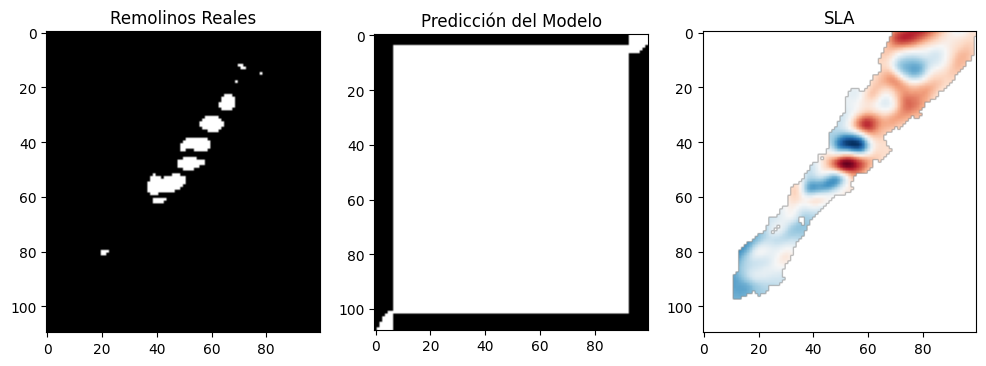

In [31]:
import matplotlib.pyplot as plt

# Hacer predicciones en los datos de entrenamiento
Y_pred = modelo.predict(X)

# Convertir a binario (umbral en 0.5)
Y_pred_bin = (Y_pred > 0.5).astype(int)

# Elegir un día aleatorio para ver la predicción
idx = np.random.randint(0, X.shape[0])

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y[idx].squeeze(), cmap="gray")
plt.title("Remolinos Reales")

plt.subplot(1, 3, 2)
plt.imshow(Y_pred_bin[idx].squeeze(), cmap="gray")
plt.title("Predicción del Modelo")

plt.subplot(1, 3, 3)
plt.imshow(X[idx, :, :, 0], cmap="RdBu_r")  # Mostrar SLA como referencia
plt.title("SLA")

plt.show()
